In [1]:
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
)
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split


import util

In [2]:
RANDOM_SEED = 42

In [3]:
ORIGINS_PATH = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
df_origins = util.load_origins_df(ORIGINS_PATH)

In [4]:
MINIMAP2_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-minimap2-ovlps.paf"
RAM_OVLPS_AI = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps-ai.tsv"
RAM_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps.paf"

In [5]:
df_ovlps_minimap2 = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(MINIMAP2_OVLPS),
    df_origins,
)

In [6]:
df_ovlps_ai_ram = (
    util.calc_ava_origin_overlap(
        util.expand_ava_with_origin_info(
            df_ava=pl.read_csv(
                RAM_OVLPS_AI,
                has_header=False,
                new_columns=util.RAM_OVERLAP_AI_COLUMNS,
                separator="\t",
            ),
            df_origins=df_origins,
        )
    )
    .select(
        *util.RAM_OVERLAP_AI_COLUMNS,
        ((pl.col("ratio") > 0.825) & pl.col("matching-strands"))
        .cast(pl.Int64)
        .alias("label"),
    )
    .with_columns(
        pl.when(pl.col("strand") == "+")
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias("strand"),
        pl.min_horizontal(
            pl.col("query-matches"),
            pl.col("target-matches"),
        ).alias("n-residue-matches"),
    )
)

In [57]:
df_ovlps_ram = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(RAM_OVLPS),
    df_origins,
)

In [58]:
print(df_ovlps_minimap2.select(pl.col("label").value_counts()))
print(df_ovlps_ai_ram.select(pl.col("label").value_counts()))
print(df_ovlps_ram.select(pl.col("label").value_counts()))

shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {1,11923}  │
│ {0,296419} │
└────────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,84169} │
│ {1,2183}  │
└───────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {1,648}   │
│ {0,33904} │
└───────────┘


In [9]:
df_experiment = (
    df_ovlps_ai_ram.with_columns(
        (pl.col("query-end") - pl.col("query-start")).alias("query-overlap-length"),
        (pl.col("target-end") - pl.col("target-start")).alias("target-overlap-length"),
    )
    .with_columns(
        pl.max_horizontal(
            pl.col("query-overlap-length"),
            pl.col("target-overlap-length"),
        ).alias("overlap-length"),
    )
    .with_columns(
        (pl.col("score") / pl.col("overlap-length")).alias("score-normed"),
        (pl.col("query-matches") / pl.col("query-overlap-length")).alias("query-matches-normed"),
        (pl.col("target-matches") / pl.col("target-overlap-length")).alias("target-matches-normed"),
        (pl.col("n-residue-matches") / pl.col("overlap-length")).alias("matches-normed"),
        (
            (pl.col("query-overlap-length") - pl.col("target-overlap-length")).abs()
            / pl.col("overlap-length")
        ).alias("overlap-length-diff-normed"),
    ).with_columns(
        (pl.col("query-matches-normed") - pl.col("target-matches-normed")).abs().alias("matches-diff-normed")
    )
)

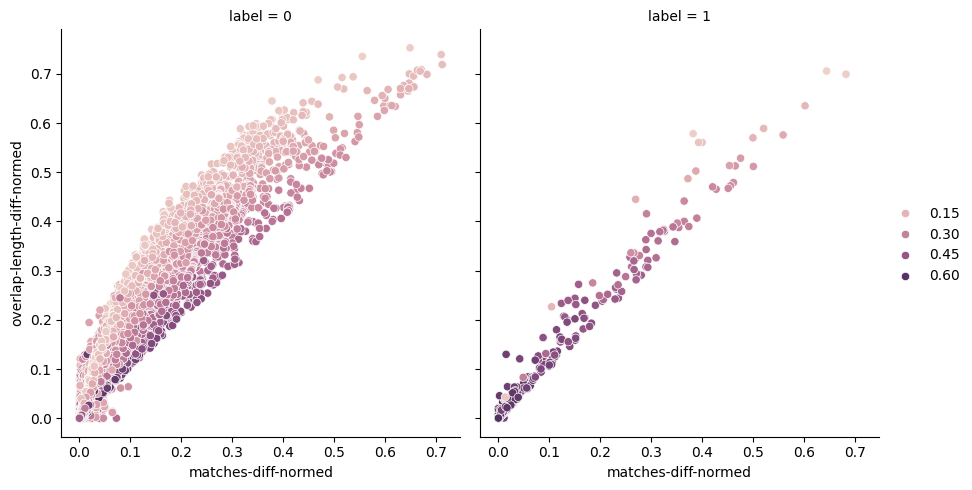

In [10]:
g = sns.FacetGrid(
    df_experiment,
    col="label",
)
g.fig.set_size_inches(9, 5)
g.map_dataframe(
    sns.scatterplot,
    x="matches-diff-normed",
    y="overlap-length-diff-normed",
    hue="score-normed",
)
g.add_legend()

In [11]:
df_features = df_experiment.select(
    (pl.col("score-normed")),
    (pl.col("matches-diff-normed")),
    (pl.col("overlap-length-diff-normed")),
    (pl.col("matches-normed")),
    pl.col("label") 
)

In [12]:
X = df_features.drop("label").to_pandas()
y = df_features["label"].to_pandas()
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [51]:
model_logistic = LogisticRegression(
    class_weight="balanced",
    random_state=RANDOM_SEED,
)
model_ridge = RidgeClassifier(
    alpha=10,
    class_weight="balanced",
    random_state=RANDOM_SEED,
)

scores_logistic = cross_val_score(model_logistic, X, y, cv=kfold, scoring="recall")
scores_ridge = cross_val_score(model_ridge, X, y, cv=kfold, scoring="recall")

print(f"scored_logistic: {scores_logistic}")
print(f"scored_ridge: {scores_ridge}")

scored_logistic: [0.89176471 0.89830508 0.9049676  0.87418655 0.88123515]
scored_ridge: [0.94117647 0.92251816 0.92440605 0.90889371 0.92874109]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, random_state=RANDOM_SEED)
model_logistic.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)

RidgeClassifier(alpha=10, class_weight='balanced', random_state=42)

In [53]:
y_pred_logistic = model_logistic.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_ridge))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     33703
           1       0.07      0.89      0.13       838

    accuracy                           0.71     34541
   macro avg       0.53      0.80      0.48     34541
weighted avg       0.97      0.71      0.81     34541

              precision    recall  f1-score   support

           0       1.00      0.68      0.81     33703
           1       0.07      0.94      0.13       838

    accuracy                           0.69     34541
   macro avg       0.53      0.81      0.47     34541
weighted avg       0.98      0.69      0.79     34541



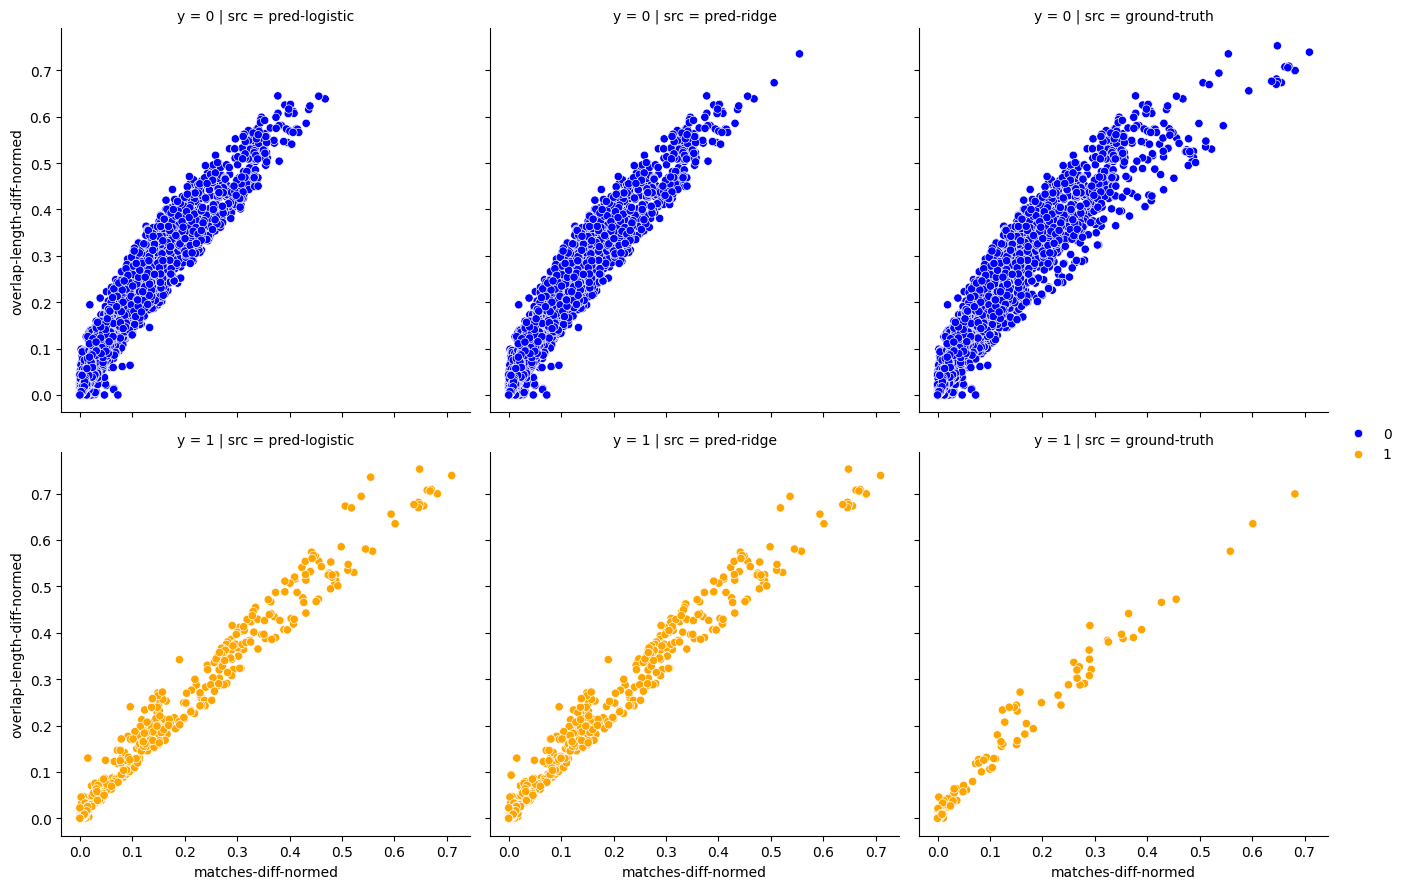

In [55]:
df_result = pd.concat(
    [
        X_test.assign(y=y_pred_logistic, src="pred-logistic"),
        X_test.assign(y=y_pred_ridge, src="pred-ridge"),
        X_test.assign(y=y_test, src="ground-truth"),
    ],
)
g = sns.FacetGrid(df_result, col="src", row="y")
g.fig.set_size_inches(13.5, 9)
g.map_dataframe(
    sns.scatterplot,
    x="matches-diff-normed",
    y="overlap-length-diff-normed",
    hue="y",
    palette={
        0: 'blue',
        1: 'orange',
    },
)
g.add_legend()

In [56]:
print(list(zip(model_ridge.feature_names_in_, *model_logistic.coef_)))
print(model_ridge.intercept_)

[('score-normed', -3.268218070659619), ('matches-diff-normed', 8.684199990524847), ('overlap-length-diff-normed', -0.32754197336799906), ('matches-normed', 10.351460182968728)]
[-2.08124118]
